In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn  
import torch.nn.functional as F
import torch
from transformers import DistilBertForSequenceClassification, AdamWeightDecay, AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


df = pd.read_csv("Dataset/raw/temporal/drugsComTest_raw.csv")
df

c:\Projecto Deep L\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


Procesamiento de los datos

In [ ]:
df_clasificado = df.query("rating >= 7 | rating <= 4").copy() # Filtramos solo las filas con rating >= 7 o <= 4
df_clasificado["flag"] = df_clasificado["rating"].apply(lambda x: 1 if x >= 7 else 0) # Clasificamos los ratings en 1 (positivo) y 0 (negativo)

df_clasificado = df_clasificado[["review", "flag"]] # Seleccionamos solo las columnas de interés
print(df_clasificado.info())# Mostramos la información del DataFrame resultante
print(df_clasificado["flag"].value_counts()) # Mostramos la distribución de clases
print("porcentaje de clase positiva: ", df_clasificado["flag"].value_counts(normalize=True)[1] * 100) # Mostramos el porcentaje de clase positiva
print("porcentaje de clase negativa: ", df_clasificado["flag"].value_counts(normalize=True)[0] * 100) # Mostramos el porcentaje de clase negativa

In [ ]:
df_clasificado

In [ ]:
def ProcessingDataframe(df, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    MODEL_NAME = 'distilbert-base-cased'
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # Longitud máxima de la secuencia (un estándar para DistilBERT)
    MAX_LEN = 256

    clase_0 = df[df["flag"] == 0]
    clase_1 = df[df["flag"] == 1]
    
    # reducción del tamaño del conjunto de datos para acelerar el entrenamiento

    clase_0_subsampled = clase_0.sample(frac=0.5, random_state=42)
    clase_1_subsampled = clase_1.sample(frac=0.5, random_state=42)

    # duplicamos la clase minoritaria
    clase_0_subsampled = pd.concat([clase_0_subsampled, clase_0_subsampled])

    df_balanced = pd.concat([clase_0_subsampled, clase_1_subsampled]).sample(frac=1, random_state=42).reset_index(drop=True) # Mezclamos las clases balanceadas  
    
    text_list = df_balanced['review'].tolist()  
    
    encoding = tokenizer.batch_encode_plus(
    text_list,
    max_length=MAX_LEN,
    padding='max_length',     # Rellena secuencias más cortas
    truncation=True,          # Corta secuencias más largas
    return_attention_mask=True, # Crea la máscara (dice dónde están los tokens reales)
    return_tensors='pt'       # Devuelve tensores de PyTorch
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # 3. Preparar Etiquetas (y)
    labels = torch.tensor(df_balanced['flag'].values)

    # 1. Dividir los datos (80% Entrenamiento, 20% Validación)
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.2, stratify=labels
    )
    train_masks, validation_masks, _, _ = train_test_split(
        attention_mask, input_ids, random_state=42, test_size=0.2, stratify=labels
    )

    # 1. Combina los tensores en un diccionario
    # El Trainer necesita las llaves 'input_ids', 'attention_mask' y 'labels'
    train_dict = {
        'input_ids': train_inputs.numpy(),
        'attention_mask': train_masks.numpy(),
        'labels': train_labels.numpy()
    }
    validation_dict = {
        'input_ids': validation_inputs.numpy(),
        'attention_mask': validation_masks.numpy(),
        'labels': validation_labels.numpy()
    }

    # 2. Crea el objeto Dataset
    train_dataset = Dataset.from_dict(train_dict)
    validation_dataset = Dataset.from_dict(validation_dict)

    # Correr los cálculos de pesos de clase
    labels = df_balanced['flag'].values
    clase_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
        )
    weights = torch.tensor(clase_weights, dtype=torch.float32).to(device)

    return train_dataset, validation_dataset, df_balanced, weights
train_dataset, validation_dataset, df_balanced, weights = ProcessingDataframe(df_clasificado)

print(df_balanced.info())# Mostramos la información del DataFrame resultante
print(df_balanced["flag"].value_counts()) # Mostramos la distribución de clases
print("porcentaje de clase positiva: ", df_balanced["flag"].value_counts(normalize=True)[1] * 100) # Mostramos el porcentaje de clase positiva
print("porcentaje de clase negativa: ", df_balanced["flag"].value_counts(normalize=True)[0] * 100)

Entrenamiento del modelo

In [ ]:
def compute_metrics(eval_pred):
    """
    Calcula las métricas de precisión (accuracy) y F1-score.
    """
    # predictions son los logits (salida cruda del modelo)
    logits, labels = eval_pred 
    
    # Tomar el argmax para obtener la clase predicha (0 o 1)
    predictions = np.argmax(logits, axis=-1)
    
    # Calcular las métricas
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary') 
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
class WeightedTrainer(Trainer):
    """
    Trainer personalizado que inyecta pesos de clase en la función de pérdida (CrossEntropyLoss).
    """
    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        # Obtener las etiquetas (y_true)
        labels = inputs.pop("labels")
        
        # Propagación hacia adelante (Forward pass)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Crear la función de pérdida CrossEntropy con los pesos de clase
        loss_fct = nn.CrossEntropyLoss(weight=weights) # 
        
        # Calcular la pérdida
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

class Trainer(Trainer):
    """
    Trainer normal sin inyeccion de pesos (CrossEntropyLoss).
    """
    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        # Obtener las etiquetas (y_true)
        labels = inputs.pop("labels")
        
        # Propagación hacia adelante (Forward pass)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Crear la función de pérdida CrossEntropy sin pesos de clase
        loss_fct = nn.CrossEntropyLoss() 
        
        # Calcular la pérdida
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
def full_training():
    MODEL_NAME = 'distilbert-base-cased'
    model = DistilBertForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels = 2,
        output_attentions = False, # No necesitamos las atenciones
        output_hidden_states = False, # No necesitamos los estados ocultos
    )
    
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # Mover el modelo a CPU (o GPU si está disponible)
    
    # 2. Definir los Argumentos de Entrenamiento (Hyperparameters)
    # El 'output_dir' es donde se guardarán los checkpoints y logs

    training_args1 = TrainingArguments(
        output_dir='./results',          # Directorio para guardar outputs
        num_train_epochs=2,              # Número total de épocas
        per_device_train_batch_size=8,  # Tamaño del batch por dispositivo (GPU/CPU)
        per_device_eval_batch_size=32,   # Tamaño del batch para evaluación
        warmup_steps=500,                # Número de pasos para el warmup del learning rate
        weight_decay=0.01,               # Descenso de peso (regularización L2)
        logging_dir='./logs',            # Directorio para los logs
        logging_steps=50,                # Registrar log cada 50 pasos
        fp16=True,               
        eval_strategy="epoch",     # Evaluar al final de cada época
        save_strategy="epoch",           # Guardar el checkpoint al final de cada época
        load_best_model_at_end=True,     # Cargar el mejor modelo después del entrenamiento
        learning_rate=2e-5,          # Tasa de aprendizaje
        dataloader_num_workers= 4     # Número de trabajadores para cargar datos              
    )

    training_args2 = TrainingArguments(
        output_dir='./results',          # Directorio para guardar outputs
        num_train_epochs=1,              # Número total de épocas
        per_device_train_batch_size=8,  # Tamaño del batch por dispositivo (GPU/CPU)
        per_device_eval_batch_size=32,   # Tamaño del batch para evaluación
        warmup_steps=500,                # Número de pasos para el warmup del learning rate
        weight_decay=0.01,               # Descenso de peso (regularización L2)
        logging_dir='./logs',            # Directorio para los logs
        logging_steps=50,                # Registrar log cada 50 pasos
        fp16=True,               
        eval_strategy="epoch",     # Evaluar al final de cada época
        save_strategy="epoch",           # Guardar el checkpoint al final de cada época
        load_best_model_at_end=True,     # Cargar el mejor modelo después del entrenamiento
        learning_rate=2e-5,          # Tasa de aprendizaje
        dataloader_num_workers= 4     # Número de trabajadores para cargar datos              
    )
    
    trainer_1= Trainer(
        model=model,                         # El modelo a entrenar
        args=training_args1,                  # Los argumentos de entrenamiento
        train_dataset=train_dataset,         # Conjunto de datos de entrenamiento
        eval_dataset=validation_dataset,     # Conjunto de datos de validación
        compute_metrics=compute_metrics      # Función para calcular métricas
    )
    
    trainer_2 = WeightedTrainer(
        model=model,                         # El modelo a entrenar
        args=training_args2,                  # Los argumentos de entrenamiento
        train_dataset=train_dataset,         # Conjunto de datos de entrenamiento
        eval_dataset=validation_dataset,     # Conjunto de datos de validación
        compute_metrics=compute_metrics      # Función para calcular métricas
    )

    
    
    # 3. Entrenar el modelo
    trainer_1.train()
    # 4. Congelar el modelo y solo entrenar la capa de clasificación
    for param in model.distilbert.parameters():
        param.requires_grad = False # Congelar todas las capas de DistilBERT    

    trainer_2.train()
    
    
    return trainer_2

print("Iniciando el entrenamiento completo con balanceo de clases...")
modelo = full_training()
print("Guardando el modelo entrenado...")
modelo.save_pretrained("Modelo_entrenado/drug_review_classifier_distilbert_fullbalance") # Guardar el modelo entrenado
print("Evaluando el modelo entrenado...")
result = modelo.evaluate()
print("Resultados de la evaluación:")
print(result)

In [ ]:
def predict_review(review_text, model, tokenizer, threshold, max_len=256):
    """
    Realiza una predicción de clasificación de texto utilizando el modelo y tokenizador proporcionados.
    """
    # Tokenizar y preparar la entrada
    encoding = tokenizer.encode_plus(
        review_text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    # Mover tensores a la misma device que el modelo
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Desactivar el cálculo de gradientes para la inferencia
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
   # 3. Obtener probabilidades (Softmax)
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # Extraer la probabilidad de la clase Positiva (asumiendo que es el índice 1)
    # *Verifica si tu clase Positiva es el índice 1*
    prob_positive = probabilities[0][1].item()
    prob_negative = probabilities[0][0].item()
    
    # 4. Ajustar la decisión según el nuevo umbral:
    if prob_positive >= threshold:
        predicted_class = 'Positivo'
    else:
        # Si no es lo suficientemente Positivo (menos del 65%), lo clasificamos como Negativo
        predicted_class = 'Negativo'
        
    return predicted_class, prob_positive, prob_negative

# Cargar el modelo y el tokenizador
MODEL_NAME = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained("Modelo_entrenado/drug_review_classifier_distilbert_fullbalance")
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # Mover el modelo a CPU (o GPU si está disponible)
# Ejemplo de uso
negative_reviews = [
    "La pastilla me causó una migraña horrible y no ayudó en absoluto con mi problema inicial. Pura basura.",
    "Tuve que dejar de tomarlo a los tres días. Los efectos secundarios eran peores que la enfermedad. Totalmente inefectivo.",
    "El producto es inútil; no sentí ningún alivio después de tomarlo durante tres semanas. Sigo igual o peor.",
    "Me sentí muy decepcionado. El medicamento no cumple lo que promete y solo es una pérdida de dinero.",
    "La farmacia tardó una semana en entregarlo y el servicio al cliente fue grosero. Pésima experiencia de compra.",
    "Este fue el peor tratamiento que he probado. El sabor es repugnante y no noté ninguna mejoría.",
    "No lo recomiendo en absoluto. Me provocó náuseas constantes y tuve que ir al médico para descontinuarlo.",
    "Esperaba mucho más de esta marca. Claramente fallaron en la formulación, ya que no tuve resultados duraderos.",
    "Compré dos cajas y ambas llegaron con el empaque roto. El medicamento es demasiado caro para esta mala calidad.",
    "No está mal, pero es muchísimo más lento de lo que publicitan. Sentí que no valió la pena la espera."
]

positive_reviews = [
    "Este medicamento me ha devuelto la calidad de vida que había perdido. Es un producto milagroso y lo recomiendo.",
    "Excelente producto. El efecto se notó en menos de 24 horas y sin efectos secundarios molestos.",
    "Estoy muy satisfecho con los resultados. Funciona exactamente como se describe en la caja. Un 10/10.",
    "El alivio que proporciona vale totalmente el precio. Es la mejor inversión que he hecho en mi salud.",
    "Fue recetado por mi médico y superó todas mis expectativas. Una maravilla, volveré a comprarlo sin duda.",
    "Aunque el envío tardó, el resultado final es tan bueno que vale la pena la espera. Funciona a la perfección.",
    "La dosis es fácil de seguir y el sabor no es tan malo como otros. Lo más importante: ¡la mejoría es notable!",
    "Mi dolor crónico ha desaparecido casi por completo. Siento una enorme gratitud por este tratamiento.",
    "Me sorprendió la eficacia con tan baja concentración. Es muy potente y no causa dependencia.",
    "El servicio al cliente fue genial, y el producto en sí me ayudó mucho más rápido de lo que esperaba."
]

for review in negative_reviews:
    prediction = predict_review(review, model, tokenizer)
    sentiment = "Positivo" if prediction == 1 else "Negativo"
    print(f"Reseña: {review}\nPredicción: {sentiment}\n")

In [ ]:

MODEL_NAME = 'distilbert-base-cased'
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels = 2,
    output_attentions = False, # No necesitamos las matrices de atención para la clasificación
    output_hidden_states = False, # No necesitamos los estados ocultos
)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # Mover el modelo a CPU (o GPU si está disponible)

# 2. Definir los Argumentos de Entrenamiento (Hyperparameters)
# El 'output_dir' es donde se guardarán los checkpoints y logs
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar outputs
    num_train_epochs=1,              # Número total de épocas
    per_device_train_batch_size=8,  # Tamaño del batch por dispositivo (GPU/CPU)
    per_device_eval_batch_size=32,   # Tamaño del batch para evaluación
    warmup_steps=500,                # Número de pasos para el warmup del learning rate
    weight_decay=0.01,               # Descenso de peso (regularización L2)
    logging_dir='./logs',            # Directorio para los logs
    logging_steps=50,                # Registrar log cada 50 pasos
    fp16=True,               
    eval_strategy="epoch",     # Evaluar al final de cada época
    save_strategy="epoch",           # Guardar el checkpoint al final de cada época
    load_best_model_at_end=True,     # Cargar el mejor modelo después del entrenamiento
    learning_rate=2e-5,          # Tasa de aprendizaje
    dataloader_num_workers= 4     # Número de trabajadores para cargar datos              
)

# 3. Crear el Objeto Trainer
trainer = WeightedTrainer(
    model=model,                         # El modelo DistilBERT
    args=training_args,                  # Los argumentos definidos
    train_dataset=train_dataset,         # El conjunto de entrenamiento
    eval_dataset=validation_dataset,     # El conjunto de validación
    compute_metrics=compute_metrics,     # La función de métricas
)

# --- Bloque de Verificación ---
print("--- Verificación de Dispositivos (GPU) ---")

# Verificar el modelo (debe ser 'cuda:0')
print(f"Modelo DistilBERT en: {next(model.parameters()).device}")

# Verificar los pesos de clase (debe ser 'cuda:0' si la GPU está activa)
print(f"Pesos de Clase (weights) en: {weights.device}")

# Verificar el primer lote de datos (Opcional, pero muy informativo)
# El Trainer usa un DataLoader para tomar los datos
temp_dataloader = trainer.get_train_dataloader()
primer_lote = next(iter(temp_dataloader))
print(f"Lote de Datos (input_ids) en: {primer_lote['input_ids'].device}")

print("------------------------------------------")

trainer.train()

model.save_pretrained("Modelo_entrenado/drug_review_classifier_distilbert") # Guardar el modelo entrenado

In [ ]:
MODEL_PATH = "Modelo_entrenado/drug_review_classifier_distilbert"

# 2. Cargar el modelo ENTRENADO (incluye los pesos ajustados y la cabeza de clasificación)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

# 3. Cargar el tokenizer (necesario para cualquier procesamiento futuro)
# Usamos el nombre base para el tokenizer, ya que no cambió.
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')

# 4. Mover el modelo al dispositivo (GPU si está disponible, CPU si no)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelo y Tokenizer cargados y listos para evaluación.")

training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=32,   # Usar un batch size de evaluación
    eval_strategy="steps",     # No importa mucho para una sola llamada a evaluate()
    logging_dir='./logs',
)

# 2. Recrear el Objeto Trainer
# Si usaste la clase WeightedTrainer, deberías definirla nuevamente aquí.
# Usaremos la clase Trainer estándar para simplificar, ya que no estamos entrenando.
trainer = Trainer(
    model=model,                         # El modelo recién cargado
    args=training_args,                  
    eval_dataset=validation_dataset,     # 📌 Tu conjunto de validación debe estar disponible
    compute_metrics=compute_metrics,     # 📌 Tu función de métricas debe estar definida
)

# 3. Ejecutar la Evaluación Final
print("Iniciando evaluación...")
results = trainer.evaluate()

# 4. Mostrar el Resultado
print("\n--- Resultados Finales ---")
print(results)

In [ ]:
MODEL_DIR = "Modelo_entrenado/drug_review_classifier_distilbert_FINAL"
model.save_pretrained(MODEL_DIR)

# Guarda el tokenizer con su vocabulario
tokenizer.save_pretrained(MODEL_DIR)

In [ ]:
# 📌 La ruta donde guardaste el modelo y tokenizer
MODEL_PATH = "Modelo_entrenado/drug_review_classifier_distilbert_FINAL" 

# 1. Cargar el modelo y tokenizer
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')

# 2. Definir dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

OPTIMAL_THRESHOLD = 0.70 

def predict_sentiment_threshold(text, model, tokenizer, device, threshold):
    # ... (Pasos 1 y 2: Tokenizar y obtener Logits)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 3. Obtener probabilidades (Softmax)
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # Extraer la probabilidad de la clase Positiva (asumiendo que es el índice 1)
    # *Verifica si tu clase Positiva es el índice 1*
    prob_positive = probabilities[0][1].item()
    prob_negative = probabilities[0][0].item()
    
    # 4. Ajustar la decisión según el nuevo umbral:
    if prob_positive >= threshold:
        predicted_class = 'Positivo'
    else:
        # Si no es lo suficientemente Positivo (menos del 65%), lo clasificamos como Negativo
        predicted_class = 'Negativo'
        
    return predicted_class, prob_positive, prob_negative

In [ ]:

count_pos = 0
count_neg = 0
mean = 0 
negative_reviews = [
    "La pastilla me causó una migraña horrible y no ayudó en absoluto con mi problema inicial. Pura basura.",
    "Tuve que dejar de tomarlo a los tres días. Los efectos secundarios eran peores que la enfermedad. Totalmente inefectivo.",
    "El producto es inútil; no sentí ningún alivio después de tomarlo durante tres semanas. Sigo igual o peor.",
    "Me sentí muy decepcionado. El medicamento no cumple lo que promete y solo es una pérdida de dinero.",
    "La farmacia tardó una semana en entregarlo y el servicio al cliente fue grosero. Pésima experiencia de compra.",
    "Este fue el peor tratamiento que he probado. El sabor es repugnante y no noté ninguna mejoría.",
    "No lo recomiendo en absoluto. Me provocó náuseas constantes y tuve que ir al médico para descontinuarlo.",
    "Esperaba mucho más de esta marca. Claramente fallaron en la formulación, ya que no tuve resultados duraderos.",
    "Compré dos cajas y ambas llegaron con el empaque roto. El medicamento es demasiado caro para esta mala calidad.",
    "No está mal, pero es muchísimo más lento de lo que publicitan. Sentí que no valió la pena la espera."
]


positive_reviews = [
    "Este medicamento me ha devuelto la calidad de vida que había perdido. Es un producto milagroso y lo recomiendo.",
    "Excelente producto. El efecto se notó en menos de 24 horas y sin efectos secundarios molestos.",
    "Estoy muy satisfecho con los resultados. Funciona exactamente como se describe en la caja. Un 10/10.",
    "El alivio que proporciona vale totalmente el precio. Es la mejor inversión que he hecho en mi salud.",
    "Fue recetado por mi médico y superó todas mis expectativas. Una maravilla, volveré a comprarlo sin duda.",
    "Aunque el envío tardó, el resultado final es tan bueno que vale la pena la espera. Funciona a la perfección.",
    "La dosis es fácil de seguir y el sabor no es tan malo como otros. Lo más importante: ¡la mejoría es notable!",
    "Mi dolor crónico ha desaparecido casi por completo. Siento una enorme gratitud por este tratamiento.",
    "Me sorprendió la eficacia con tan baja concentración. Es muy potente y no causa dependencia.",
    "El servicio al cliente fue genial, y el producto en sí me ayudó mucho más rápido de lo que esperaba."
]

OPTIMAL_THRESHOLD = 0.73 
for text in positive_reviews:   #positive_reviews o  negative_reviews
    sentiment, prob_pos, prob_neg = predict_sentiment_threshold(text, model, tokenizer, device, OPTIMAL_THRESHOLD)
    mean += prob_pos / len(neg_text)
    if sentiment == 'Positivo':
        count_pos += 1
    else:
        count_neg += 1
        
    print(f"Resultado: {sentiment} (Probabilidad_positiva: {prob_pos:.2f}) (Probabilidad_negativa: {prob_neg:.2f})")
print(f"Positivos: {count_pos}, Negativos: {count_neg}\n") 
print(f"Mean probabilidad positiva: {mean:.2f}")
print(f"threhold: {OPTIMAL_THRESHOLD}")  

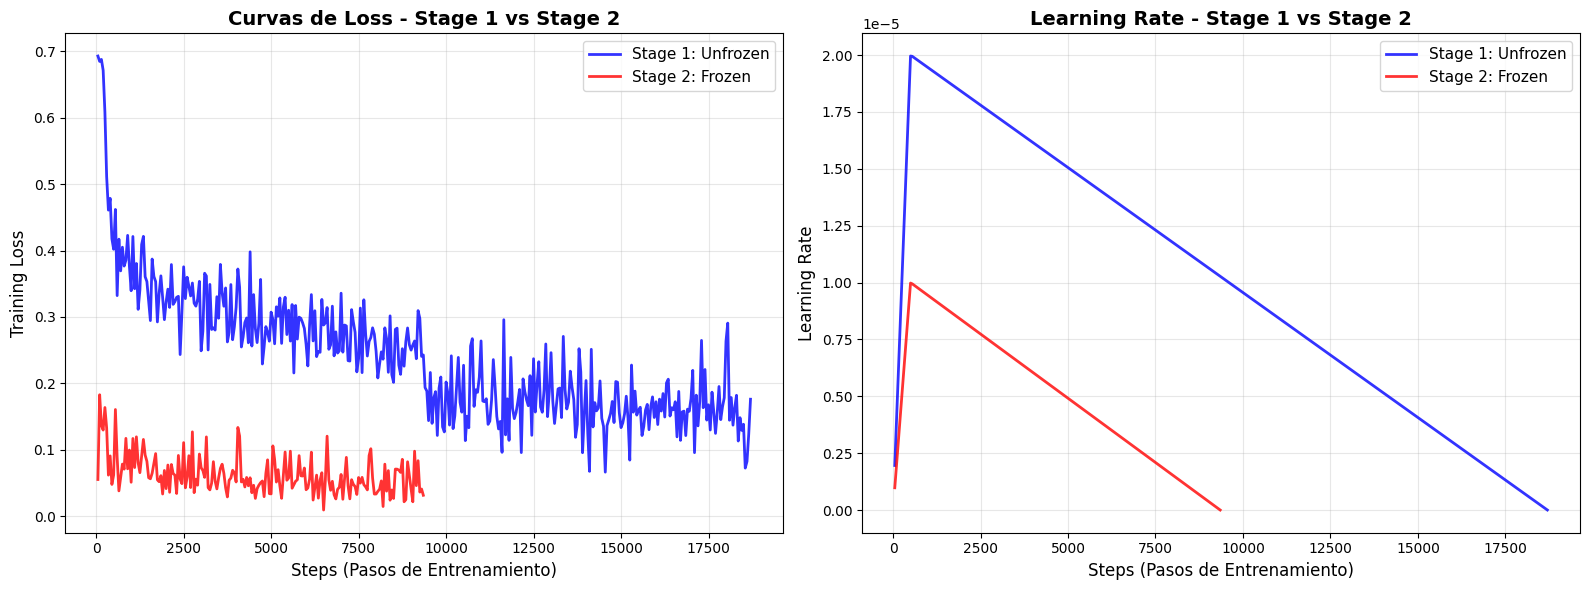

In [3]:

import json
import matplotlib.pyplot as plt
import os

def plot_loss_and_lr(ruta_json_stage1, ruta_json_stage2):
    # Leer datos de Stage 1
    with open(os.path.join(ruta_json_stage1, 'trainer_state.json'), 'r') as f:
        data_stage1 = json.load(f)
    
    history_s1 = data_stage1['log_history']
    steps_s1 = [e['step'] for e in history_s1 if 'loss' in e]
    loss_s1 = [e['loss'] for e in history_s1 if 'loss' in e]
    lrs_s1 = [e['learning_rate'] for e in history_s1 if 'learning_rate' in e]
    
    # Leer datos de Stage 2
    with open(os.path.join(ruta_json_stage2, 'trainer_state.json'), 'r') as f:
        data_stage2 = json.load(f)
    
    history_s2 = data_stage2['log_history']
    steps_s2 = [e['step'] for e in history_s2 if 'loss' in e]
    loss_s2 = [e['loss'] for e in history_s2 if 'loss' in e]
    lrs_s2 = [e['learning_rate'] for e in history_s2 if 'learning_rate' in e]
    
    # Crear figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Gráfica 1: Loss Functions ---
    ax1.plot(steps_s1, loss_s1, label='Stage 1: Unfrozen', color='blue', alpha=0.8, linewidth=2)
    ax1.plot(steps_s2, loss_s2, label='Stage 2: Frozen', color='red', alpha=0.8, linewidth=2)
    ax1.set_title('Curvas de Loss - Stage 1 vs Stage 2', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Steps (Pasos de Entrenamiento)', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # --- Gráfica 2: Learning Rate ---
    ax2.plot(steps_s1, lrs_s1, label='Stage 1: Unfrozen', color='blue', alpha=0.8, linewidth=2)
    ax2.plot(steps_s2, lrs_s2, label='Stage 2: Frozen', color='red', alpha=0.8, linewidth=2)
    ax2.set_title('Learning Rate - Stage 1 vs Stage 2', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Steps (Pasos de Entrenamiento)', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()

# Llamar a la función
plot_loss_and_lr(
    'results/stage_1_unfrozen/checkpoint-18702',
    'results/stage_2_frozen/checkpoint-9351'
)